In [56]:
from tsai.all import *
import os
import torchvision.models as models
import torch.nn as nn
import pandas as pd
from torchvision.io import read_image
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import torchvision
from glob import glob
from torchinfo import summary
import numpy as np
import torch.nn.functional as F
import torchvision.transforms as T
from tqdm.auto import tqdm
import torchmetrics
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score
device0 = torch.device("cuda:7" if torch.cuda.is_available() else "cpu")
batch_size = 1

def createDirectory(directory):
    """_summary_
        create Directory
    Args:
        directory (string): file_path
    """    
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print("Error: Failed to create the directory.")

In [33]:
#fit
def resized(data,N):
    M=data.size
    res=np.empty(N,data.dtype)
    carry=0
    m=0
    for n in range(N):
        sum = carry
        while m*N - n*M < M :
            sum += data[m]
            m += 1
        carry = (m-(n+1)*M/N)*data[m-1]
        sum -= carry
        res[n] = sum*N/M
    return res
class CustomDataset(Dataset):
    def __init__(self,path,data,label ,transform=None, target_transform=None):
        self.PPG_data=data
        self.PPG_label=label
        self.PPG_path=path
    def __len__(self):
        return len(self.PPG_data)

    def __getitem__(self, idx):
        signal_path=self.PPG_path[idx]
        signal_tensor=self.PPG_data[idx]
        AF_signal_label=self.PPG_label[idx]
        return signal_path,signal_tensor,AF_signal_label
    

test_csv_path ='../../data/MixArtifacts/b30sec/test/'
test_df=pd.read_csv('../../data/MixArtifacts/b30sec/test.csv',encoding='cp949')

test_data=torch.empty(len(test_df),1,3000)
test_label=torch.empty(len(test_data),1)
file_list=[]
for i in tqdm(range(len(test_df))):
    file_name=test_df.loc[i]['FileName']
    file_list.append(file_name)
    AF_signal_label=test_df.loc[i]['AF']
    signal_csv=pd.read_csv(test_csv_path+file_name)['PPG'].to_numpy()
    test_data[i]=torch.tensor(signal_csv)
    test_label[i]=torch.tensor([AF_signal_label])


test_dataset=CustomDataset(file_list,test_data,test_label)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

  0%|          | 0/11580 [00:00<?, ?it/s]

In [61]:
def test(model,dataloader):
    validation_tqdm=tqdm(dataloader)
    accuracy = torchmetrics.Accuracy(task="binary", num_classes=1).to(device0)
    model.eval()
    val_count=0
    path_list=[]
    y_list=[]
    predict_list=[]
    val_running_loss=0.0
    val_acc_loss=0
    criterion = nn.BCEWithLogitsLoss().to(device0)
    with torch.no_grad():
        for path,x, y in validation_tqdm:
            
            path_list.append(path)
            y_list.append(y.item())
            y = y.to(device0).float()
            val_count+=1
            x=x.to(device0).float()
            
            predict = model(x).to(device0)
            predict_list.append(F.sigmoid(predict).item())
            acc=accuracy(predict, y)
            cost = criterion(predict, y)
            val_running_loss+=cost.item()
            val_acc_loss+=acc
        print(f"accuracy: {val_acc_loss/val_count:.4f}")
    return path_list,y_list,predict_list
model = gMLP(1,1,3000).to(device0)
model.load_state_dict(torch.load('../../model/architecture_waveform/PPG_gMLP_callback.pt'), strict=False)
gMLP_path,gMLP_y,gMLP_pred=test(model,test_dataloader)
model = XCM(1,1,3000).to(device0)
model.load_state_dict(torch.load('../../model/architecture_waveform/PPG_XCM_callback.pt'), strict=False)
XCM_path,XCM_y,XCM_pred=test(model,test_dataloader)
model = ResCNN(1,1).to(device0)
model.load_state_dict(torch.load('../../model/architecture_waveform/PPG_ResCNN_callback.pt'), strict=False)
ResCNN_path,ResCNN_y,ResCNN_pred=test(model,test_dataloader)
model =OmniScaleCNN(1,1,3000).to(device0)
model.load_state_dict(torch.load('../../model/architecture_waveform/PPG_OmniScaleCNN_callback.pt'), strict=False)
OmniScaleCNN_path,OmniScaleCNN_y,OmniScaleCNN_pred=test(model,test_dataloader)
model = TCN(1,1).to(device0)
model.load_state_dict(torch.load('../../model/architecture_waveform/PPG_TCN_callback.pt'), strict=False)
TCN_path,TCN_y,TCN_pred=test(model,test_dataloader)
model =XceptionTimePlus(1,1,3000).to(device0)
model.load_state_dict(torch.load('../../model/architecture_waveform/PPG_XceptionTimePlus_callback.pt'), strict=False)
XceptionTime_path,XceptionTime_y,XceptionTime_pred=test(model,test_dataloader)
model = MLSTM_FCN(1,1,3000).to(device0)
model.load_state_dict(torch.load('../../model/architecture_waveform/PPG_MLSTM_FCN_callback.pt'), strict=False)
MLSTM_FCN_path,MLSTM_FCN_y,MLSTM_FCN_pred=test(model,test_dataloader)
model =GRU_FCN(1,1,3000).to(device0)
model.load_state_dict(torch.load('../../model/architecture_waveform/PPG_GRU_FCN_callback.pt'), strict=False)
GRU_FCN_path,GRU_FCN_y,GRU_FCN_pred=test(model,test_dataloader)

  0%|          | 0/11580 [00:00<?, ?it/s]

accuracy: 0.4469


  0%|          | 0/11580 [00:00<?, ?it/s]

accuracy: 0.4469


  0%|          | 0/11580 [00:00<?, ?it/s]

accuracy: 0.9411


  0%|          | 0/11580 [00:00<?, ?it/s]

accuracy: 0.8801


  0%|          | 0/11580 [00:00<?, ?it/s]

accuracy: 0.9518


  0%|          | 0/11580 [00:00<?, ?it/s]

accuracy: 0.9306


  0%|          | 0/11580 [00:00<?, ?it/s]

accuracy: 0.9065


  0%|          | 0/11580 [00:00<?, ?it/s]

accuracy: 0.9015


(0.0, 1.0)

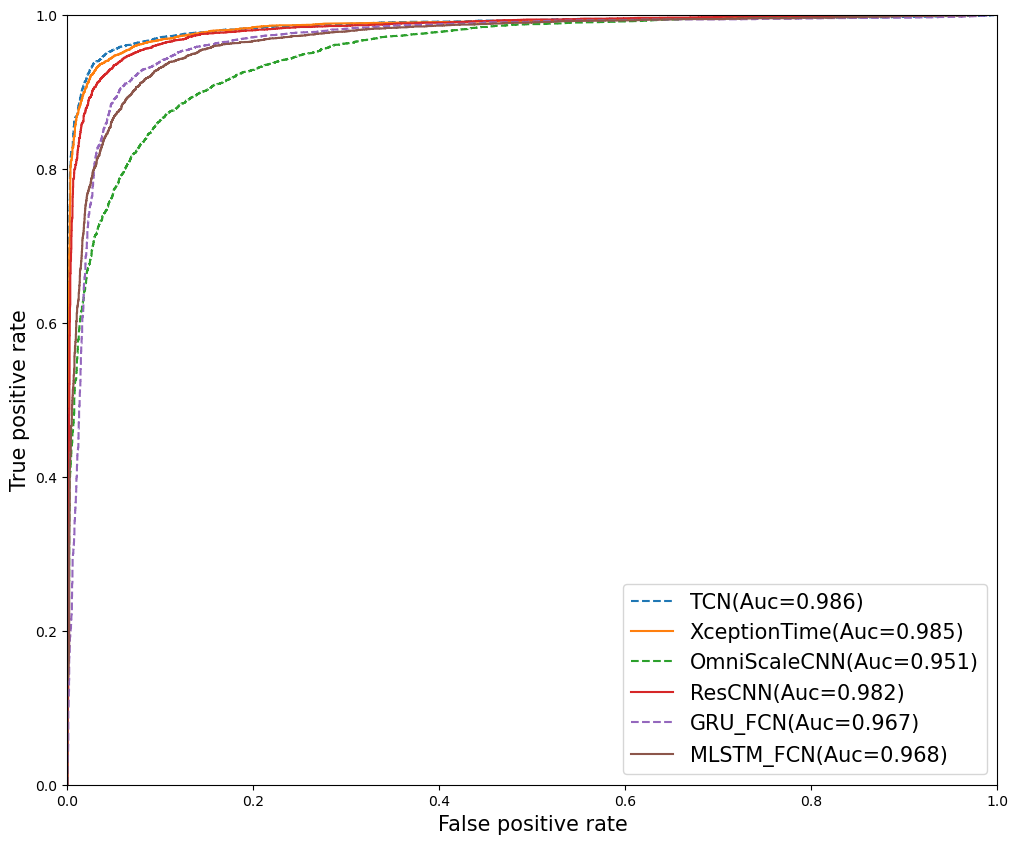

In [83]:
ResCNN_fper,ResCNN_tper, thresholds = roc_curve(ResCNN_y, ResCNN_pred)
OmniScaleCNN_fper,OmniScaleCNN_tper, thresholds = roc_curve(ResCNN_y, OmniScaleCNN_pred)
TCN_fper,TCN_tper, thresholds = roc_curve(ResCNN_y, TCN_pred)
XceptionTime_fper,XceptionTime_tper, thresholds = roc_curve(ResCNN_y, XceptionTime_pred)
MLSTM_FCN_fper,MLSTM_FCN_tper, thresholds = roc_curve(ResCNN_y, MLSTM_FCN_pred)
GRU_FCN_fper,GRU_FCN_tper, thresholds = roc_curve(ResCNN_y, GRU_FCN_pred)
ResCNN_auc_score=roc_auc_score(ResCNN_y, ResCNN_pred)
OmniScaleCNN_auc_score=roc_auc_score(ResCNN_y, OmniScaleCNN_pred)
TCN_auc_score=roc_auc_score(ResCNN_y, TCN_pred)
XceptionTime_auc_score=roc_auc_score(ResCNN_y, XceptionTime_pred)
MLSTM_FCN_auc_score=roc_auc_score(ResCNN_y, MLSTM_FCN_pred)
GRU_FCN_auc_score=roc_auc_score(ResCNN_y, GRU_FCN_pred)
plt.figure(figsize=(12,10))
plt.plot(TCN_fper, TCN_tper,label='TCN(Auc='+str(round(TCN_auc_score, 3))+')',linestyle='--')
plt.plot(XceptionTime_fper, XceptionTime_tper,label='XceptionTime(Auc='+str(round(XceptionTime_auc_score, 3))+')')
plt.plot(OmniScaleCNN_fper, OmniScaleCNN_tper,label='OmniScaleCNN(Auc='+str(round(OmniScaleCNN_auc_score, 3))+')',linestyle='--')
plt.plot(ResCNN_fper,ResCNN_tper,label='ResCNN(Auc='+str(round(ResCNN_auc_score, 3))+')')
plt.plot(GRU_FCN_fper,GRU_FCN_tper,label='GRU_FCN(Auc='+str(round(GRU_FCN_auc_score, 3))+')',linestyle='--')
plt.plot(MLSTM_FCN_fper,MLSTM_FCN_tper,label='MLSTM_FCN(Auc='+str(round(MLSTM_FCN_auc_score, 3))+')')
plt.legend(loc='lower right',fontsize=15)
plt.xlabel('False positive rate',size=15)
plt.ylabel('True positive rate',size=15)
plt.xlim([0, 1])      # X축의 범위: [xmin, xmax]
plt.ylim([0, 1]) 


In [82]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils import resample
def weight_metrics(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    f1 = f1_score(y_true, y_pred,average='macro')
    weight=f1+sensitivity/4
    return weight
# Define a function to find the optimal threshold
def find_optimal_threshold(y_true, y_scores):
    thresholds = np.arange(0.01, 1.0, 0.01)
    f1_scores = [weight_metrics(y_true, (y_scores > t).astype(int)) for t in thresholds]
    optimal_threshold = thresholds[np.argmax(f1_scores)]
    return optimal_threshold

# Find optimal threshold for each model
TCN_optimal_threshold = find_optimal_threshold(ResCNN_y,TCN_pred)
XceptionTime_optimal_threshold = find_optimal_threshold(ResCNN_y, XceptionTime_pred)
OmniScaleCNN_optimal_threshold = find_optimal_threshold(ResCNN_y, OmniScaleCNN_pred)
ResCNN_optimal_threshold = find_optimal_threshold(ResCNN_y, ResCNN_pred)
GRU_FCN_optimal_threshold = find_optimal_threshold(ResCNN_y, GRU_FCN_pred)
MLSTM_FCN_optimal_threshold = find_optimal_threshold(ResCNN_y, MLSTM_FCN_pred)
# Define a function to calculate metrics
def calculate_metrics(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred,average='macro')
    return sensitivity, specificity, accuracy, f1

def bootstrap_ci(metric, y_true, y_pred, n_iterations=1000, ci=95):
    values = []
    for _ in range(n_iterations):
        indices = resample(range(len(y_true)), replace=True)
        resampled_true = y_true[indices]
        resampled_pred = y_pred[indices]
        values.append(metric(resampled_true, resampled_pred))
    
    alpha = (100 - ci) / 2.0
    lower = max(0.0, np.percentile(values, alpha))
    upper = min(1.0, np.percentile(values, 100 - alpha))
    
    return lower, upper

def performance_ci(model_name,test,predict,threshold):
    ci_auc_lower, ci_auc_upper = bootstrap_ci(roc_auc_score, test, predict)
    ci_sensitivity_lower, ci_sensitivity_upper = bootstrap_ci(recall_score, test, (predict >threshold).astype(int))
    ci_specificity_lower, ci_specificity_upper = bootstrap_ci(
    lambda x, y: confusion_matrix(x, y).ravel()[0] / (confusion_matrix(x, y).ravel()[0] + confusion_matrix(x, y).ravel()[1]),
    test,
    (predict > threshold).astype(int)
)
    ci_accuracy_lower, ci_accuracy_upper = bootstrap_ci(accuracy_score, test, (predict >threshold).astype(int))
    ci_f1_lower, ci_f1_upper = bootstrap_ci(f1_score, test, (predict >threshold).astype(int))
    print("{}: AUC={}({}-{}), Sensitivity={}({}-{}), Specificity={}({}-{}), Accuracy={}({}-{}), F1-Score={}({}-{})".format(model_name,round((ci_auc_upper+ci_auc_lower)/2,3),round(ci_auc_lower,3),round(ci_auc_upper,3),round((ci_sensitivity_upper+ci_sensitivity_lower)/2,3),round(ci_sensitivity_lower,3), round(ci_sensitivity_upper,3),round((ci_specificity_upper+ci_specificity_lower)/2,3),round(ci_specificity_lower,3),round(ci_specificity_upper,3), round((ci_accuracy_upper+ci_accuracy_lower)/2,3),round(ci_accuracy_lower,3),round(ci_accuracy_upper,3), round((ci_f1_upper+ci_f1_lower)/2,3),round(ci_f1_lower,3),round(ci_f1_upper,3)))
    
# Calculate metrics for each model
TCN_sensitivity,TCN_specificity,TCN_accuracy,TCN_f1 = calculate_metrics(ResCNN_y, (ResCNN_pred >TCN_optimal_threshold ).astype(int))
XceptionTime_sensitivity, XceptionTime_specificity, XceptionTime_accuracy, XceptionTime_f1 = calculate_metrics(ResCNN_y, (XceptionTime_pred > XceptionTime_optimal_threshold).astype(int))
OmniScaleCNN_sensitivity, OmniScaleCNN_specificity, OmniScaleCNN_accuracy, OmniScaleCNN_f1 = calculate_metrics(ResCNN_y, (OmniScaleCNN_pred > OmniScaleCNN_optimal_threshold).astype(int))
ResCNN_sensitivity, ResCNN_specificity, ResCNN_accuracy, ResCNN_f1 = calculate_metrics(ResCNN_y, (ResCNN_pred > ResCNN_optimal_threshold).astype(int))
GRU_FCN_sensitivity, GRU_FCN_specificity, GRU_FCN_accuracy, GRU_FCN_f1 = calculate_metrics(ResCNN_y, (GRU_FCN_pred > GRU_FCN_optimal_threshold).astype(int))
MLSTM_FCN_sensitivity, MLSTM_FCN_specificity, MLSTM_FCN_accuracy, MLSTM_FCN_f1 = calculate_metrics(ResCNN_y, (MLSTM_FCN_pred > MLSTM_FCN_optimal_threshold).astype(int))


print("model performance(95% CI)")
performance_ci('TCN',np.array(ResCNN_y),np.array(TCN_pred),TCN_optimal_threshold)
performance_ci('XceptionTime',np.array(ResCNN_y),np.array(XceptionTime_pred),XceptionTime_optimal_threshold)
performance_ci('OmniScaleCNN',np.array(ResCNN_y),np.array(OmniScaleCNN_pred),OmniScaleCNN_optimal_threshold)
performance_ci('ResCNN',np.array(ResCNN_y),np.array(ResCNN_pred),ResCNN_optimal_threshold)
performance_ci('GRU_FCN',np.array(ResCNN_y),np.array(GRU_FCN_pred),GRU_FCN_optimal_threshold)
performance_ci('MLSTM_FCN',np.array(ResCNN_y),np.array(MLSTM_FCN_pred),MLSTM_FCN_optimal_threshold)


model performance(95% CI)
TCN: AUC=0.986(0.983-0.988), Sensitivity=0.955(0.95-0.96), Specificity=0.95(0.944-0.956), Accuracy=0.953(0.949-0.957), F1-Score=0.957(0.954-0.96)
XceptionTime: AUC=0.984(0.982-0.987), Sensitivity=0.947(0.941-0.952), Specificity=0.95(0.944-0.956), Accuracy=0.948(0.944-0.952), F1-Score=0.953(0.949-0.957)
OmniScaleCNN: AUC=0.951(0.947-0.954), Sensitivity=0.909(0.903-0.916), Specificity=0.841(0.83-0.851), Accuracy=0.878(0.872-0.884), F1-Score=0.892(0.887-0.897)
ResCNN: AUC=0.982(0.98-0.984), Sensitivity=0.946(0.941-0.952), Specificity=0.935(0.929-0.942), Accuracy=0.941(0.937-0.946), F1-Score=0.947(0.943-0.951)
GRU_FCN: AUC=0.967(0.964-0.97), Sensitivity=0.951(0.946-0.956), Specificity=0.88(0.872-0.889), Accuracy=0.92(0.915-0.925), F1-Score=0.929(0.925-0.934)
MLSTM_FCN: AUC=0.968(0.965-0.971), Sensitivity=0.938(0.932-0.944), Specificity=0.89(0.882-0.899), Accuracy=0.917(0.912-0.923), F1-Score=0.926(0.921-0.93)


In [110]:
class CustomDataset(Dataset):
    def __init__(self,path,data,label ,transform=None, target_transform=None):
        self.PPG_data=data
        self.PPG_label=label
        self.PPG_path=path
    def __len__(self):
        return len(self.PPG_data)

    def __getitem__(self, idx):
        signal_path=self.PPG_path[idx]
        signal_tensor=self.PPG_data[idx]
        AF_signal_label=self.PPG_label[idx]
        return signal_path,signal_tensor,AF_signal_label
    

real_csv_list =glob('../../data/nor_collection/**/*.csv')

file_list=[]
real_data=torch.empty(len(real_csv_list),1,3000)
real_label=torch.empty(len(real_data),1)
for i in tqdm(range(len(real_csv_list))):
    AF_signal_label=0
    file_name=real_csv_list[i]
    file_list.append(file_name)
    signal_csv=pd.read_csv(real_csv_list[i])['PPG'].to_numpy()
    real_data[i]=torch.tensor(signal_csv)
    real_label[i]=torch.tensor([AF_signal_label])   
def test(model,dataloader,optim1):
    validation_tqdm=tqdm(dataloader)
    accuracy = torchmetrics.Accuracy(task="binary", num_classes=1).to(device0)
    model.eval()
    val_count=0
    path_list=[]
    y_list=[]
    predict_list=[]
    val_running_loss=0.0
    val_acc_loss=0
    criterion = nn.BCEWithLogitsLoss().to(device0)
    with torch.no_grad():
        for path,x, y in validation_tqdm:
            
            path_list.append(path)
            y_list.append(y.item())
            y = y.to(device0).float()
            val_count+=1
            x=x.to(device0).float()
            
            predict = model(x).to(device0)
            predict_list.append(F.sigmoid(predict).item())
            acc=accuracy(F.sigmoid(predict)>optim1, y)
            cost = criterion(predict, y)
            val_running_loss+=cost.item()
            val_acc_loss+=acc
        print(f"accuracy: {val_acc_loss/val_count:.4f}")
    return path_list,y_list,predict_list

real_dataset=CustomDataset(file_list,real_data,real_label)
real_dataloader = DataLoader(real_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
model = gMLP(1,1,3000).to(device0)
model.load_state_dict(torch.load('../../model/architecture_waveform/PPG_gMLP_callback.pt'), strict=False)
gMLP_path,gMLP_y,gMLP_pred=test(model,real_dataloader,0.5)
model = XCM(1,1,3000).to(device0)
model.load_state_dict(torch.load('../../model/architecture_waveform/PPG_XCM_callback.pt'), strict=False)
XCM_path,XCM_y,XCM_pred=test(model,real_dataloader,0.5)
model = ResCNN(1,1).to(device0)
model.load_state_dict(torch.load('../../model/architecture_waveform/PPG_ResCNN_callback.pt'), strict=False)
ResCNN_path,ResCNN_y,ResCNN_pred=test(model,real_dataloader,ResCNN_optimal_threshold)
model =OmniScaleCNN(1,1,3000).to(device0)
model.load_state_dict(torch.load('../../model/architecture_waveform/PPG_OmniScaleCNN_callback.pt'), strict=False)
OmniScaleCNN_path,OmniScaleCNN_y,OmniScaleCNN_pred=test(model,real_dataloader,OmniScaleCNN_optimal_threshold)
model = TCN(1,1).to(device0)
model.load_state_dict(torch.load('../../model/architecture_waveform/PPG_TCN_callback.pt'), strict=False)
TCN_path,TCN_y,TCN_pred=test(model,real_dataloader,TCN_optimal_threshold)
model =XceptionTimePlus(1,1,3000).to(device0)
model.load_state_dict(torch.load('../../model/architecture_waveform/PPG_XceptionTimePlus_callback.pt'), strict=False)
XceptionTime_path,XceptionTime_y,XceptionTime_pred=test(model,real_dataloader,XceptionTime_optimal_threshold)
model = MLSTM_FCN(1,1,3000).to(device0)
model.load_state_dict(torch.load('../../model/architecture_waveform/PPG_MLSTM_FCN_callback.pt'), strict=False)
MLSTM_FCN_path,MLSTM_FCN_y,MLSTM_FCN_pred=test(model,real_dataloader,MLSTM_FCN_optimal_threshold)
model =GRU_FCN(1,1,3000).to(device0)
model.load_state_dict(torch.load('../../model/architecture_waveform/PPG_GRU_FCN_callback.pt'), strict=False)
GRU_FCN_path,GRU_FCN_y,GRU_FCN_pred=test(model,real_dataloader,GRU_FCN_optimal_threshold)

  0%|          | 0/1030 [00:00<?, ?it/s]

  0%|          | 0/1030 [00:00<?, ?it/s]

accuracy: 0.0000


  0%|          | 0/1030 [00:00<?, ?it/s]

accuracy: 0.1388


  0%|          | 0/1030 [00:00<?, ?it/s]

accuracy: 0.6592


  0%|          | 0/1030 [00:00<?, ?it/s]

accuracy: 0.6728


  0%|          | 0/1030 [00:00<?, ?it/s]

accuracy: 0.8175


  0%|          | 0/1030 [00:00<?, ?it/s]

accuracy: 0.9864


  0%|          | 0/1030 [00:00<?, ?it/s]

accuracy: 0.0951


  0%|          | 0/1030 [00:00<?, ?it/s]

accuracy: 0.9485


In [117]:
np.std(np.array([0.210 , 0.229 ,0.061]))

0.07511916459126053